# From X-rays to a Production Classifier with MLflow

This simple example will demonstrate how to build a chest X-Ray classifer with PyTorch Lightning, and explain its output, but more importantly, will demonstrate how to manage the model's deployment to production as a REST service with MLflow and its Model Registry.

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/shap.png" width="600"/>

The National Institute of Health (NIH) [released a dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) of 45,000 chest X-rays of patients who may suffer from some problem in the chest cavity, along with several of 14 possible diagnoses. This was accompanied by a [paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) analyzing the data set and presenting a classification model.

The task here is to train a classifier that learns to predict these diagnoses. Note that each image may have 0 or several 'labels'. This data set was the subject of a [Kaggle competition](https://www.kaggle.com/nih-chest-xrays/data) as well.

In [0]:
%pip install pytorch-lightning shap mlflow==1.13.1

Python interpreter will be restarted.
Collecting pytorch-lightning
 Downloading pytorch_lightning-1.1.5-py3-none-any.whl (685 kB)
Collecting shap
 Downloading shap-0.38.1.tar.gz (352 kB)
Collecting mlflow==1.13.1
 Downloading mlflow-1.13.1-py3-none-any.whl (14.1 MB)
Requirement already satisfied: torch>=1.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (1.7.0)
Requirement already satisfied: PyYAML>=5.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (5.3.1)
Collecting fsspec[http]>=0.8.1
 Downloading fsspec-0.8.5-py3-none-any.whl (98 kB)
Requirement already satisfied: tensorboard>=2.2.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (2.3.0)
Requirement already satisfied: future>=0.17.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (0.18.2)
Requirement already satisfied: tqdm>=4.41.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (4.42.1)
Requirement already satisfied: numpy>=1.16.6 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from pytorch-lightning) (1.18.1)
Requirement already satisfied: scipy in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from shap) (1.4.1)
Requirement already satisfied: scikit-learn in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from shap) (0.22.1)
Requirement already satisfied: pandas in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from shap) (1.0.1)
Collecting slicer==0.0.7
 Downloading slicer-0.0.7-py3-none-any.whl (14 kB)
Collecting numba
 Downloading numba-0.52.0-cp37-cp37m-manylinux2014_x86_64.whl (3.2 MB)
Requirement already satisfied: cloudpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from shap) (1.4.1)
Requirement already satisfied: click>=7.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (7.0)
Requirement already satisfied: querystring-parser in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (1.2.4)
Requirement already satisfied: databricks-cli>=0.8.7 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (0.14.0)
Requirement already satisfied: gitpython>=2.1.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (3.1.0)
Collecting alembic<=1.4.1
 Downloading alembic-1.4.1.tar.gz (1.1 MB)
Collecting prometheus-flask-exporter
 Downloading prometheus_flask_exporter-0.18.1.tar.gz (21 kB)
Requirement already satisfied: requests>=2.17.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (2.22.0)
Requirement already satisfied: entrypoints in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (0.3)
Collecting sqlalchemy
 Downloading SQLAlchemy-1.3.22-cp37-cp37m-manylinux2010_x86_64.whl (1.3 MB)
Requirement already satisfied: python-dateutil in /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d36ee72-eb8d-40b7-9740-d3d54e5bb992/lib/python3.7/site-packages (from mlflow==1.13.1) (2.8.1)
Requirement already satisfied: Flask in /local_disk0/.ephemeral_nfs/envs/pythonEnv

## Data Engineering

The image data is provided as a series of [compressed archives](https://nihcc.app.box.com/v/ChestXray-NIHCC). However they are also available [from Kaggle](https://www.kaggle.com/nih-chest-xrays/data) with other useful information, like labels and bounding boxes. In this problem, only the images will be used, unpacked into an `.../images/` directory,, and the CSV file of label information `Data_Entry_2017.csv` at a `.../metadata/` path.

The images can be read directly and browsed with Apache Spark:

In [0]:
raw_image_df = spark.read.format("image").load("/mnt/databricks-datasets-private/ML/nih_xray/images/")
display(raw_image_df)

image


### Managing Unstructured Data with Delta Lake

Although the images can be read directly as files, it will be useful to manage the data as a [Delta](https://delta.io/) table:

- Delta provides transactional updates, so that the data set can be updated, and still read safely while being updated
- Delta provides ["time travel"](https://docs.delta.io/latest/quick-start.html#read-older-versions-of-data-using-time-travel) to view previous states of the data set
- Reading batches of image data is more efficient from Delta than from many small files
- The image data needs some one-time preprocessing beforehand anyway

In this case, the images are all 1024 x 1024 grayscale images, though some arrive as 4-channel RGBA. They are normalized to 224 x 224 single-channel image data:

In [0]:
from pyspark.sql.types import BinaryType, StringType
from PIL import Image
import numpy as np

def to_grayscale(data, channels):
  np_array = np.array(data, dtype=np.uint8)
  if channels == 1: # assume mode = 0
    grayscale = np_array.reshape((1024,1024))
  else: # channels == 4 and mode == 24
    reshaped = np_array.reshape((1024,1024,4))
    # Data is BGRA; ignore alpha and use ITU BT.709 luma conversion:
    grayscale = (0.0722 * reshaped[:,:,0] + 0.7152 * reshaped[:,:,1] + 0.2126 * reshaped[:,:,2]).astype(np.uint8)
  # Use PIL to resize to match DL model that it will feed
  resized = Image.frombytes('L', (1024,1024), grayscale).resize((224,224), resample=Image.LANCZOS)
  return np.asarray(resized, dtype=np.uint8).flatten().tobytes()

to_grayscale_udf = udf(to_grayscale, BinaryType())
to_filename_udf = udf(lambda f: f.split("/")[-1], StringType())

image_df = raw_image_df.select(
  to_filename_udf("image.origin").alias("origin"),
  to_grayscale_udf("image.data", "image.nChannels").alias("image"))

The file of metadata links the image file name to its labels. These are parsed and joined, written to a Delta table, and registered in the metastore:

In [0]:
raw_metadata_df = spark.read.\
  option("header", True).option("inferSchema", True).\
  csv("/mnt/databricks-datasets-private/ML/nih_xray/metadata/").\
  select("Image Index", "Finding Labels")

display(raw_metadata_df)

Image Index,Finding Labels
00000001_000.png,Cardiomegaly
00000001_001.png,Cardiomegaly|Emphysema
00000001_002.png,Cardiomegaly|Effusion
00000002_000.png,No Finding
00000003_000.png,Hernia
00000003_001.png,Hernia
00000003_002.png,Hernia
00000003_003.png,Hernia|Infiltration
00000003_004.png,Hernia
00000003_005.png,Hernia


In [0]:
from pyspark.sql.functions import explode, split
from pyspark.sql.types import BooleanType, StructType, StructField

distinct_findings = sorted([r["col"] for r in raw_metadata_df.select(explode(split("Finding Labels", r"\|"))).distinct().collect() if r["col"] != "No Finding"])
encode_findings_schema = StructType([StructField(f.replace(" ", "_"), BooleanType(), False) for f in distinct_findings])

def encode_finding(raw_findings):
  findings = raw_findings.split("|")
  return [f in findings for f in distinct_findings]

encode_finding_udf = udf(encode_finding, encode_findings_schema)

metadata_df = raw_metadata_df.withColumn("encoded_findings", encode_finding_udf("Finding Labels")).select("Image Index", "encoded_findings.*")

table_path = "/tmp/sean.owen/image_table/"
metadata_df.join(image_df, metadata_df["Image Index"] == image_df["origin"]).drop("Image Index", "origin").
  write.mode("overwrite").format("delta").save(table_path)

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS nih_xray;
USE nih_xray;
CREATE TABLE IF NOT EXISTS images USING DELTA LOCATION '/tmp/sean.owen/image_table/';

## Modeling with PyTorch Lightning and MLflow

[PyTorch](https://pytorch.org/) is of course one of the most popular tools for building deep learning models, and is well suited to build a convolutional neural net that works well as a multi-label classifier for these images. Below, other related tools like [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) and [PyTorch Lightning](https://www.pytorchlightning.ai/) are used to simplify expressing and building the classifier.

The data set isn't that large once preprocessed - about 2.2GB. For simplicity, the data will be loaded and manipulated with [`pandas`](https://pandas.pydata.org/) from the Delta table, and model trained on one GPU. It's also quite possible to scale to multiple GPUs, or scale across machines with Spark and [Horovod](https://github.com/horovod/horovod), but it won't be necessary to add that complexity in this example.

In [0]:
from sklearn.model_selection import train_test_split

df = spark.read.table("nih_xray.images")

train_pd, test_pd = train_test_split(df.toPandas(), test_size=0.1, random_state=42)

frac_positive = train_pd.drop("image", axis=1).sum().sum() / train_pd.drop("image", axis=1).size
disease_names = df.drop("image").columns
num_classes = len(disease_names)

`torchvision` provides utilities that make it simple to perform some model-specific transformation as part of the model. Here, a pre-trained network will be used which requires normalized 3-channel RGB data as PyTorch Tensors:

In [0]:
from torchvision import transforms

transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Lambda(lambda image: image.convert('RGB')),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Define the `Dataset` and train/test `DataLoader`s for this data set in PyTorch:

In [0]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class XRayDataset(Dataset):
  def __init__(self, data_pd, transforms):
    self.data_pd = data_pd
    self.transforms = transforms
    
  def __len__(self):
    return len(self.data_pd)
  
  def __getitem__(self, idx):
    image = np.frombuffer(self.data_pd["image"].iloc[idx], dtype=np.uint8).reshape((224,224))
    labels = self.data_pd.drop("image", axis=1).iloc[idx].values.astype(np.float32)
    return self.transforms(image), labels

train_loader = DataLoader(XRayDataset(train_pd, transforms), batch_size=64, num_workers=8, shuffle=True)
test_loader = DataLoader(XRayDataset(test_pd, transforms), batch_size=64, num_workers=8)

Note that [MLflow](https://mlflow.org/) natively supports [logging PyTorch models](https://mlflow.org/docs/latest/python_api/mlflow.pytorch.html#module-mlflow.pytorch) of course, but, can also automatically log the output of models defined with PyTorch Lightning:

In [0]:
import mlflow.pytorch

mlflow.pytorch.autolog()

Finally, the model is defined, and fit. For simple purposes here, the model itself is quite simple: it employs the pretrained [densenet121](https://pytorch.org/hub/pytorch_vision_densenet/) layers to do most of the work (layers which are not further trained here), and simply adds some dropout and a dense layer on top to perform the classification. No attempt is made here to tune the network's architecture or parameters further.

For those new to PyTorch Lightning, it is still "PyTorch", but removes the need to write much of PyTorch's boilerplate code. Instead, a `LightningModule` class is implemented with key portions like model definition and fitting processes defined.

_Note: This section should be run on a GPU. An NVIDIA T4 GPU is recommended, though any modern GPU should work. This code can also be easily changed to train on CPUs or TPUs._

In [0]:
import torch
from torch.optim import Adam
from torch.nn import Dropout, Linear
from torch.nn.functional import binary_cross_entropy_with_logits
from sklearn.metrics import log_loss
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class XRayNNLightning(pl.LightningModule):
  def __init__(self, learning_rate, pos_weights):
    super(XRayNNLightning, self).__init__()
    self.densenet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
    for param in self.densenet.parameters():
      param.requires_grad = False
    self.dropout = Dropout(0.5)
    self.linear = Linear(1000, num_classes)
    # No sigmoid here; output logits
    self.learning_rate = learning_rate
    self.pos_weights = pos_weights

  def get_densenet():
    return self.densenet
    
  def forward(self, x):
    x = self.densenet(x)
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=self.learning_rate)

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    output = self.forward(x)
    # Outputting logits above lets us use binary_cross_entropy_with_logits for efficiency, but also, allows the use of
    # pos_weight to express that positive labels should be given much more weight. 
    # Note this was also proposed in the paper linked above.
    loss = binary_cross_entropy_with_logits(output, y, pos_weight=torch.tensor(self.pos_weights).to(self.device))
    self.log('train_loss', loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    output = self.forward(x)
    val_loss = binary_cross_entropy_with_logits(output, y, pos_weight=torch.tensor(self.pos_weights).to(self.device))
    self.log('val_loss', val_loss)

model = XRayNNLightning(learning_rate=0.001, pos_weights=[[1.0 / frac_positive] * num_classes])

# Let PyTorch handle learning rate, batch size tuning, as well as early stopping.
# Change here to configure for CPUs or TPUs.
trainer = pl.Trainer(gpus=1, max_epochs=20, 
                     auto_scale_batch_size='binsearch',
                     auto_lr_find=True,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=True)])
trainer.fit(model, train_loader, test_loader)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /local_disk0/.ephemeral_nfs/envs/pythonEnv-8d896525-4e84-4b08-ad51-0ab32d061a57/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /local_disk0/.ephemeral_nfs/envs/pythonEnv-8d896525-4e84-4b08-ad51-0ab32d061a57/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
 0%| | 0.00/30.8M [00:00<?, ?B/s] 2%|▏ | 784k/30.8M [00:00<00:03, 8.02MB/s] 5%|▌ | 1.55M/30.8M [00:00<00:03, 8.08MB/s] 14%|█▍ | 4.32M/30.8M [00:00<00:02, 10.3MB/s] 60%|█████▉ | 18.4M/30.8M [00:00<00:00, 14.3MB/s]100%|██████████| 30.8M/30.8M [00:00<00:00, 71.5MB/s]
EarlyStopping mode set to min for monitoring val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021/01/08 18:54:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b955015aa64f4c689ec21c7beff0ea3b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow

 Name | Type | Params
--------------------------------------
0 | densenet | DenseNet | 8.0 M 
1 | dropout | Dropout | 0 
2 | linear | Linear | 14.0 K
--------------------------------------
14.0 K Trainable params
8.0 M Non-trainable params
8.0 M Total params
INFO:lightning:
 Name | Type | Params
--------------------------------------
0 | densenet | DenseNet | 8.0 M 
1 | dropout | Dropout | 0 
2 | linear | Linear | 14.0 K
--------------------------------------
14.0 K Trainable params
8.0 M Non-trainable params
8.0 M Total params
Validation sanity check: 0it [00:00, ?it/s]Validation sanity check: 50%|█████ | 1/2 [00:01<00:01, 1.80s/it]Validation sanity check: 100%|██████████| 2/2 [00:01<00:00, 1.32s/it] Training: 0it [00:00, ?it/s]Training: 0%| | 0/704 [00:00<?, ?it/s]Epoch 0: 0%| | 0/704 [00:00<?, ?it/s] Epoch 0: 0%| | 1/704 [00:00<09:44, 1.20it/s]Epoch 0: 0%| | 1/704 [00:00<09:45, 1.20it/s, loss=1.96, v_num=1]Epoch 0: 0%| | 2/704 [00:01<06:11, 1.89it/s, loss=1.96, v_num=1]Epoch 0: 0%| | 2/704 [00:01<06:11, 1.89it/s, loss=1.92, v_num=1]Epoch 0: 0%| | 3/704 [00:01<04:57, 2.36it/s, loss=1.92, v_num=1]Epoch 0: 0%| | 3/704 [00:01<04:57, 2.36it/s, loss=1.94, v_num=1]Epoch 0: 1%| | 4/704 [00:01<04:19, 2.69it/s, loss=1.94, v_num=1]Epoch 0: 1%| | 4/704 [00:01<04:19, 2.69it/s, loss=1.86, v_num=1]Epoch 0: 1%| | 5/704 [00:01<03:57, 2.94it/s, loss=1.86, v_num=1]Epoch 0: 1%| | 5/704 [00:01<03:57, 2.94it/s, loss=1.78, v_num=1]Epoch 0: 1%| | 6/704 [00:01<03:42, 3.14it/s, loss=1.78, v_num=1]Epoch 0: 1%| | 6/704 [00:01<03:42, 3.14it/s, loss=1.74, v_num=1]Epoch 0: 1%| | 7/704 [00:02<03:31, 3.29it/s, loss=1.74, v_num=1]Epoch 0: 1%| | 7/704 [00:02<03:31, 3.29it/s, loss=1.72, v_num=1]Epoch 0: 1%| | 8/704 [00:02<03:23, 3.43it/s, loss=1.72, v_num=1]Epoch 0: 1%| | 8/704 [00:02<03:23, 3.43it/s, loss=1.67, v_num=1]Epoch 0: 1%|▏ | 9/704 [00:02<03:16, 3.53it/s, loss=1.67, v_num=1]Epoch 0: 1%|▏ | 9/704 [00:02<03:16, 3.53it/s, loss=1.67, v_num=1]Epoch 0: 1%|▏ | 10/704 [00:02<03:11, 3.63it/s, loss=1.67, v_num=1]Epoch 0: 1%|▏ | 10/704 [00:02<03:11, 3.63it/s, loss=1.63, v_num=1]Epoch 0: 2%|▏ | 11/704 [00:02<03:07, 3.70it/s, loss=1.63, v_num=1]Epoch 0: 2%|▏ | 11/704 [00:02<03:07, 3.70it/s, loss=1.63, v_num=1]Epoch 0: 2%|▏ | 12/704 [00:03<03:03, 3.77it/s, loss=1.63, v_num=1]Epoch 0: 2%|▏ | 12/704 [00:03<03:03, 3.77it/s, loss=1.62, v_num=1]Epoch 0: 2%|▏ | 13/704 [00:03<03:00, 3.83it/s, loss=1.62, v_num=1]Epoch 0: 2%|▏ | 13/704 [00:03<03:00, 3.83it/s, loss=1.6, v_num=1] Epoch 0: 2%|▏ | 14/704 [00:03<02:57, 3.89it/s, loss=1.6, v_num=1]Epoch 0: 2%|▏ | 14/704 [00:03<02:57, 3.89it/s, loss=1.59, v_num=1]Epoch 0: 2%|▏ | 15/704 [00:03<02

Although not shown here for brevity, this model's results are comparable to those cited in the [paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) - about 0.6-0.7 AUC for each of the 14 classes. The auto-logged results are available in MLflow:

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/pytorch_params.png" width="600"/> <img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/pytorch_artifacts.png" width="600"/>

### PSA: Don't Try (To Diagnose Chest X-rays) At Home!

The author is not a doctor, and probably neither are you! It should be said that this is _not_ necessarily the best model, and certainly should not be used to actually diagnose patients! It's just an example.

## Serving the Model with MLflow

This auto-logged model is useful raw material. The goal is to deploy it as a REST API, and [MLflow can create a REST API and Docker container](https://mlflow.org/docs/latest/models.html#deploy-mlflow-models) around a `pyfunc` model, and even deploy to Azure ML or AWS SageMaker for you. It can also be deployed within Databricks for testing.

However, there are a few catches which mean we can't directly deploy the model above:

- It accepts images as input, but these can't be directly specified in the JSON request to the REST API
- Its output are logits, when probabilities (and label names) would be more useful

It is however easy to define a custom `PythonModel` that will wrap the PyTorch model and perform additional pre- and post-processing. This model accepts a base64-encoded image file, and returns the probability each label:

In [0]:
import torch
import pandas as pd
import numpy as np
import base64
from io import BytesIO
from PIL import Image
from mlflow.pyfunc import PythonModel

class XRayNNServingModel(PythonModel):
  def __init__(self, model, transforms, disease_names):
    self.model = model
    self.transforms = transforms
    self.disease_names = disease_names
    
  def get_model():
    return self.model
  
  def get_transforms():
    return self.transforms
  
  def get_disease_names():
    return disease_names

  def predict(self, context, model_input):
    def infer(b64_string):
      encoded_image = base64.decodebytes(bytearray(b64_string, encoding="utf8"))
      image = Image.open(BytesIO(encoded_image)).convert(mode='L').resize((224,224), resample=Image.LANCZOS)
      image_bytes = np.asarray(image, dtype=np.uint8)
      transformed = self.transforms(image_bytes).unsqueeze(dim=0)
      output = self.model(transformed).squeeze()
      return torch.sigmoid(output).tolist()
    return pd.DataFrame(model_input.iloc[:,0].apply(infer).to_list(), columns=disease_names)

Now the new wrapped model is logged with MLflow:

In [0]:
import mlflow.pyfunc
import mlflow.pytorch
import mlflow.models
import pytorch_lightning as pl
import PIL
import torchvision

# Load PyTorch Lightning model
# TODO: replace the run ID with the one created above
model = mlflow.pytorch.load_model("runs:/b955015aa64f4c689ec21c7beff0ea3b/model", map_location='cpu')

with mlflow.start_run():
  model_env = mlflow.pyfunc.get_default_conda_env()
  # Record specific additional dependencies required by the serving model
  model_env['dependencies'][-1]['pip'] += [
    f'torch=={torch.__version__}',
    f'torchvision=={torchvision.__version__}',
    f'pytorch-lightning=={pl.__version__}',
    f'pillow=={PIL.__version__}',
  ]
  # Log the model signature - just creates some dummy data of the right type to infer from
  signature = mlflow.models.infer_signature(
    pd.DataFrame(["dummy"], columns=["image"]),
    pd.DataFrame([[0.0] * num_classes], columns=disease_names))
  python_model = XRayNNServingModel(model, transforms, disease_names)
  mlflow.pyfunc.log_model("model", python_model=python_model, signature=signature, conda_env=model_env)

### Registering the Model with MLflow

The [MLflow Model Registry](https://databricks.com/product/mlflow-model-registry) provides workflow management for the model promotion process, from Staging to Production. The new run created above can be registered directly from the MLflow UI:

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/register_model.png" width="800"/>

It can then be transitioned into the Production state directly, for simple purposes here. After that, enabling serving within Databricks is as simple as turning it on in the models' Serving tab:

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/serving.png" width="800"/>

### Accessing the Model with a REST Request

Now, we can send images to the REST endpoint and observe its classifications. This could power a simple web application, but here, to demonstrate, it is called directly from a notebook.

In [0]:
dbutils.widgets.removeAll()
dbutils.widgets.text("Path", "/dbfs/mnt/databricks-datasets-private/ML/nih_xray/images/00000001_000.png", "Path")

Out[2]:

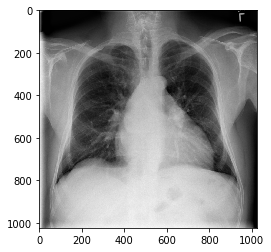

<matplotlib.image.AxesImage at 0x7f651fcbcbd0>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = dbutils.widgets.get("Path")
plt.imshow(mpimg.imread(image_path), cmap='gray')

In [0]:
import base64
import requests
import pandas as pd

with open(image_path, "rb") as file:
  content = file.read()

dataset = pd.DataFrame([base64.encodebytes(content)], columns=["image"])
# Note that you will still need a Databricks access token to send with the request. This can/should be stored as a secret in the workspace:
token = dbutils.secrets.get("demo-token-sean.owen", "token")

response = requests.request(method='POST',
                            headers={'Authorization': f'Bearer {token}'}, 
                            url='https://demo.cloud.databricks.com/model/nih_xray/3/invocations',
                            json=dataset.to_dict(orient='split'))
pd.DataFrame(response.json())

Out[3]:

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.619971,0.171794,0.22542,0.059416,0.470096,0.151376,0.194671,0.000412,0.859002,0.504999,0.431818,0.487303,0.055094,0.547313


The model suggests that a doctor might examine this X-ray for Atelectasis and Infiltration, but a Hernia is unlikely, for example.
But, why did the model think so? Fortunately there are tools that can explain the model's output in this case, and this will be demonstrated a little later.

## Adding Webhooks for Model State Management

[MLflow can now trigger webhooks](https://databricks.com/blog/2020/11/19/mlflow-model-registry-on-databricks-simplifies-mlops-with-ci-cd-features.html) when Model Registry events happen. Webhooks are standard 'callbacks' which let applications signal one another. For example, a webhook can cause a CI/CD test job to start and run tests on a model. In this simple example, we'll just set up a webhook that posts a message to a Slack channel.

_Note_: the example below requires a [registered Slack webhook](https://api.slack.com/messaging/webhooks). Because the webhook URL is sensitive, it is stored as a secret in the workspace and not included inline.

In [0]:
from mlflow.tracking.client import MlflowClient
from mlflow.utils.rest_utils import http_request
import json

def mlflow_call_endpoint(endpoint, method, body = '{}'):
  client = MlflowClient()
  host_creds = client._tracking_client.store.get_host_creds()
  if method == 'GET':
    response = http_request(host_creds=host_creds, endpoint=f"/api/2.0/mlflow/{endpoint}", method=method, params=json.loads(body))
  else:
    response = http_request(host_creds=host_creds, endpoint=f"/api/2.0/mlflow/{endpoint}", method=method, json=json.loads(body))
  return response.json()

json_obj = {
  "model_name": "nih_xray",
  "events": ["MODEL_VERSION_CREATED", "TRANSITION_REQUEST_CREATED", "MODEL_VERSION_TRANSITIONED_STAGE", "COMMENT_CREATED", "MODEL_VERSION_TAG_SET"],
  "http_url_spec": { "url": dbutils.secrets.get("demo-token-sean.owen", "slack_webhook") }
}
mlflow_call_endpoint("registry-webhooks/create", "POST", body=json.dumps(json_obj))

As model versions are added, transitioned among stages, commented on, etc. a webhook will fire.

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/slack.png" width="800"/>

## Explaining Predictions

[SHAP](https://shap.readthedocs.io/en/latest/) is a popular tool for explaining model predictions. It can explain virtually any classifier or regressor at the prediction level, and estimate how much each input feature contributed positively or negatively to the result, and by how much.

In MLflow 1.12 and later, SHAP model explanations can be [logged automatically](https://www.mlflow.org/docs/latest/python_api/mlflow.shap.html):

<img src="https://www.mlflow.org/docs/latest/_images/shap-ui-screenshot.png" width="800"/>

However, this model's inputs are not simple scalar features, but an image. SHAP does have tools like `GradExplainer` and `DeepExplainer` that are specifically designed to explain neural nets' classification of images. To use this, we do have to use SHAP manually instead of via MLflow's automated tools. However the result can be, for example, logged with a model in MLflow.

Here we explain the model's top classification, and generate a plot showing which parts of the image most strongly move the prediction positively (red) or negatively (blue). The explanation is traced back to an early intermediate layer of densenet121.

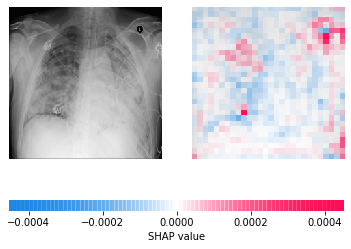

In [0]:
import numpy as np
import torch
import mlflow.pyfunc
import shap

# Load the latest production model and its components
pyfunc_model = mlflow.pyfunc.load_model("models:/nih_xray/production")
transforms = pyfunc_model._model_impl.python_model.transforms
model = pyfunc_model._model_impl.python_model.model
disease_names = pyfunc_model._model_impl.python_model.disease_names

# Let's pick an example that definitely exhibits some affliction
df = spark.read.table("nih_xray.images")
first_row = df.filter("Infiltration").select("image").limit(1).toPandas()
image = np.frombuffer(first_row["image"].item(), dtype=np.uint8).reshape((224,224))

# Only need a small sample for explanations
sample = df.sample(0.02).select("image").toPandas()
sample_tensor = torch.cat([transforms(np.frombuffer(sample["image"].iloc[idx], dtype=np.uint8).reshape((224,224))).unsqueeze(dim=0) for idx in range(len(sample))])

e = shap.GradientExplainer((model, model.densenet.features[6]), sample_tensor, local_smoothing=0.1)
shap_values, indexes = e.shap_values(transforms(image).unsqueeze(dim=0), ranked_outputs=3, nsamples=300)

shap.image_plot(shap_values[0][0].mean(axis=0, keepdims=True),
                transforms(image).numpy().mean(axis=0, keepdims=True))

In [0]:
import pandas as pd

pd.DataFrame(torch.sigmoid(model(transforms(image).unsqueeze(dim=0))).detach().numpy(), columns=disease_names).iloc[:,indexes.numpy()[0]]

Out[14]:

,Infiltration,Edema,Atelectasis
0,0.920406,0.833984,0.733611


This suggests that the small region at the top of left lung is more significant in causing the model to produce its positive classifications for Infiltration, Effusion and Cardiomegaly than most of the image, and the bottom of the left lung however contradicts those to some degree and is associated with lower probability of that classification.

## Managing Notebooks with Projects

This notebook exists within a Project. This means it and any related notebooks are backed by a Git repository. The notebook can be committed, along with other notebooks, and observed in the source Git repository.

<img src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/nih_xray/git.png" width="600"/>